In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
)

import scipy.stats as stats
import pingouin as pg
import shap

from catboost import Pool, CatBoostClassifier

import warnings

warnings.filterwarnings("ignore")

/home/erdi/miniconda3/envs/stable/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_to_minutes(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan
    try:
        parts = time_str.split(":")
        if len(parts) == 2:
            hours = int(parts[0])
            minutes_val = int(parts[1])
            return hours * 60 + minutes_val
        elif len(parts) == 1 and parts[0].strip() != "":
            return int(parts[0])
        else:
            return np.nan
    except ValueError:
        return np.nan

In [5]:
# Read the dataset
df = pd.read_csv("../data/2023_yili_yangin_mudahale_istatistigi.csv")

# Drop unnecessary columns
drop_columns = [
    "_id",
    "TARIH",
    "ERKEK_VEFAT",
    "KADIN_VEFAT",
    "ITFAIYECI_VEFAT",
    "ERKEK_YARALI",
    "KADIN_YARALI",
    "ITFAIYECI_YARALI",
    "BUYUK_BAS_VEFAT",
    "KUCUK_BAS_VEFAT",
    "KUMES_HAYVANI_VEFAT",
    "EVCIL_HAYVAN_VEFAT",
    "DIGER HAYVAN",
]

# Convert time columns to minutes
df["VARIS_SURESI (DAK.)"] = df["VARIS_SURESI (DAK.)"].apply(convert_to_minutes)
df["EKIPLERIN_CIKIS_SAATI"] = df["EKIPLERIN_CIKIS_SAATI"].apply(convert_to_minutes)
# df["EKIPLERIN_CIKIS_SAATI"] = df["EKIPLERIN_CIKIS_SAATI"].apply(lambda x: np.sin(2 * np.pi * x / 1440))
df["EKIPLERIN_CIKIS_SAATI"] = df["EKIPLERIN_CIKIS_SAATI"].apply(lambda x: x / 24 * 60)

# Sum up the total number of deaths and injuries
df["TOTAL_VEFAT"] = df["ERKEK_VEFAT"].fillna(0) + df["KADIN_VEFAT"].fillna(0) + df["ITFAIYECI_VEFAT"].fillna(0)
df["TOTAL_YARALI"] = df["ERKEK_YARALI"].fillna(0) + df["KADIN_YARALI"].fillna(0) + df["ITFAIYECI_YARALI"].fillna(0)
df["TOTAL_HAYVAN_VEFAT"] = (
    df["BUYUK_BAS_VEFAT"].fillna(0)
    + df["KUCUK_BAS_VEFAT"].fillna(0)
    + df["KUMES_HAYVANI_VEFAT"].fillna(0)
    + df["EVCIL_HAYVAN_VEFAT"].fillna(0)
    + df["DIGER HAYVAN"].fillna(0)
)

# Fill missing values in YAPI_SEKLI column with "YAPI_DEGIL"
df["YAPI_SEKLI"] = df["YAPI_SEKLI"].fillna("YAPI_DEGIL")

# Drop the unnecessary columns
df.drop(columns=drop_columns, inplace=True)

# Rename columns for consistency
df = df.rename(
    columns={
        "VARIS_SURESI (DAK.)": "VARIS_SURESI",
        "KULLANILAN_KOPUK_MIKTARI (KG)": "KULLANILAN_KOPUK_MIKTARI",
        "KULLANILAN_SU_MIKTARI (m3)": "KULLANILAN_SU_MIKTARI",
        "KULLANILAN_KURU_KIMYEVI_TOZ_MIKTARI (KG)": "KULLANILAN_KURU_KIMYEVI_TOZ_MIKTARI",
    }
)

# Drop rows with missing values
df = df.dropna()

df.to_csv("../data/2023_yili_yangin_mudahale_istatistigi_cleaned.csv", index=False)
df.head()

,YANGIN_TURU,YANGIN_SEBEBI,YANGIN_SONUCU,YAPI_SEKLI,VARIS_SURESI,KULLANILAN_KOPUK_MIKTARI,KULLANILAN_SU_MIKTARI,KULLANILAN_KURU_KIMYEVI_TOZ_MIKTARI,EKIPLERIN_CIKIS_SAATI,ILCE,ADRES_BOLGESI,TOTAL_VEFAT,TOTAL_YARALI,TOTAL_HAYVAN_VEFAT
0,BİNA,KIVILCIM(BACA),BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,4.0,0.0,1.0,0.0,45.0,KARABAĞLAR,KENT MERKEZİ,0,0,0
1,ÇÖP,SİGARA/KİBRİT,BAŞLANGIÇTA SÖNDÜRÜLEN,YAPI_DEGIL,3.0,0.0,0.5,0.0,245.0,KONAK,KENT MERKEZİ,0,0,0
2,BİNA,ŞÜPHELİ,BAŞLANGIÇTA SÖNDÜRÜLEN,BETONARME,2.0,0.0,0.0,0.0,275.0,KONAK,KENT MERKEZİ,0,0,0
3,ARAÇ,KAZA SONUCU,KISMEN YANARAK KURTARILAN,YAPI_DEGIL,4.0,0.0,2.0,0.0,305.0,BORNOVA,KENT MERKEZİ,0,0,0
4,ARAÇ,İHMAL/DİKKATSİZLİK,BAŞLANGIÇTA SÖNDÜRÜLEN,YAPI_DEGIL,6.0,0.0,0.4,0.0,360.0,URLA,KENT MERKEZİ,0,2,0


In [6]:
# General grouping of the YANGIN_TURU column to reduce the number of unique values
# and make the data more manageable for analysis
yangin_turu_mapper = {
    # Bitki Örtüsü - Tarımsal Alan Yangınları
    "OT": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "AĞAÇ": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "KARGILIK": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "ORMAN/FİDANLIK": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "BAĞ/BAHÇE": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "EKİN/SAMAN": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "MAKİLİK/ÇALI": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "ZEYTİNLİK": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "ANIZ": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    "PARK": "Bitki Örtüsü - Tarımsal Alan Yangınları",
    # Yapı - Mesken Yangınları
    "BİNA": "Yapı - Mesken Yangınları",
    "İŞYERİ": "Yapı - Mesken Yangınları",
    "FABRİKA/ATÖLYE/İMALATHANE": "Yapı - Mesken Yangınları",
    "BARAKA/KULÜBE/YAŞAM KONTEYNERİ": "Yapı - Mesken Yangınları",
    "ODUNLUK/KÖMÜRLÜK": "Yapı - Mesken Yangınları",
    "DAM/AHIR/AĞIL/AMBAR": "Yapı - Mesken Yangınları",
    "DAM/AHIR/AĞIL": "Yapı - Mesken Yangınları",
    "İNŞAAT ALANI": "Yapı - Mesken Yangınları",
    "KÜMES": "Yapı - Mesken Yangınları",
    "SERA": "Yapı - Mesken Yangınları",
    "TAVUK ÇİFTLİĞİ": "Yapı - Mesken Yangınları",
    # Araç Yangınları
    "ARAÇ": "Araç Yangınları",
    "MOTOSİKLET": "Araç Yangınları",
    "İŞ MAKİNESİ": "Araç Yangınları",
    "GEMİ/TEKNE": "Araç Yangınları",
    "ARAÇ-TEHLİKELİ MAD TAŞIYAN": "Araç Yangınları",
    "TREN": "Araç Yangınları",
    # Atık - Hurda - Depolanmış Malzeme Yangınları
    "ÇÖP": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "LASTİK": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "HURDA-AÇIK ALANDA": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "AÇIK ALAN DEPO": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "ODUN/KÖMÜR-AÇIK ALANDA": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "GÜBRE": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "HURDALIK": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "KERESTE/PALET VB": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    "KERESTE/PALET VB.": "Atık - Hurda - Depolanmış Malzeme Yangınları",
    # Altyapı - Ekipman Yangınları
    "TRAFO": "Altyapı - Ekipman Yangınları",
    "KABLO/DİREK-ELEKT/TEL VB": "Altyapı - Ekipman Yangınları",
    "SİGORTA PANO-BİNADAN BAĞIMSIZ": "Altyapı - Ekipman Yangınları",
    "REKLAM/İŞYERİ TABELASI/PANOSU VB": "Altyapı - Ekipman Yangınları",
    "PİKNİK TÜPÜ": "Altyapı - Ekipman Yangınları",
    "ÜSTGEÇİT ASANSÖRÜ": "Altyapı - Ekipman Yangınları",
    # Diğer - Belirsiz Yangınlar
    "DİĞER": "Diğer - Belirsiz Yangınlar",
    "SANDALYE": "Diğer - Belirsiz Yangınlar",
    "METAN GAZI": "Diğer - Belirsiz Yangınlar",
    "KIZILAY BAĞIŞ KUTUSU": "Diğer - Belirsiz Yangınlar",
}
df["YANGIN_TURU"] = df["YANGIN_TURU"].map(yangin_turu_mapper)

df = df.dropna()

In [7]:
df["YANGIN_TURU"].value_counts()

YANGIN_TURU
Bitki Örtüsü - Tarımsal Alan Yangınları         4982
Atık - Hurda - Depolanmış Malzeme Yangınları    3361
Yapı - Mesken Yangınları                        3108
Araç Yangınları                                 1098
Altyapı - Ekipman Yangınları                     366
Diğer - Belirsiz Yangınlar                        56
Name: count, dtype: int64

In [8]:
# Pretrain the data to see importance of the features
no_scale_features = ["EKIPLERIN_CIKIS_SAATI"]

numerical_features = [
    "VARIS_SURESI",
    "KULLANILAN_KOPUK_MIKTARI",
    "KULLANILAN_SU_MIKTARI",
    "KULLANILAN_KURU_KIMYEVI_TOZ_MIKTARI",
    "TOTAL_VEFAT",
    "TOTAL_YARALI",
    "TOTAL_HAYVAN_VEFAT",
]

categorical_features = ["YANGIN_SEBEBI", "YAPI_SEKLI", "ILCE", "ADRES_BOLGESI", "YANGIN_SONUCU"]

target = "YANGIN_TURU"

X = df[no_scale_features + numerical_features + categorical_features]

y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

catboost_classifier = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=3, cat_features=categorical_features, verbose=100, random_seed=42)
catboost_classifier.fit(X_train, y_train)

0:	learn: 1.5707509	total: 54.7ms	remaining: 54.6s
100:	learn: 0.4850839	total: 987ms	remaining: 8.79s
200:	learn: 0.4587625	total: 1.96s	remaining: 7.79s
300:	learn: 0.4458120	total: 2.88s	remaining: 6.7s
400:	learn: 0.4370699	total: 3.69s	remaining: 5.51s
500:	learn: 0.4297409	total: 4.51s	remaining: 4.5s
600:	learn: 0.4228208	total: 5.34s	remaining: 3.55s
700:	learn: 0.4167926	total: 6.23s	remaining: 2.66s
800:	learn: 0.4110887	total: 7.11s	remaining: 1.77s
900:	learn: 0.4056695	total: 7.99s	remaining: 878ms
999:	learn: 0.4004223	total: 8.87s	remaining: 0us


Top 5 feature importances:['YAPI_SEKLI', 'YANGIN_SEBEBI', 'ILCE', 'KULLANILAN_SU_MIKTARI', 'EKIPLERIN_CIKIS_SAATI']


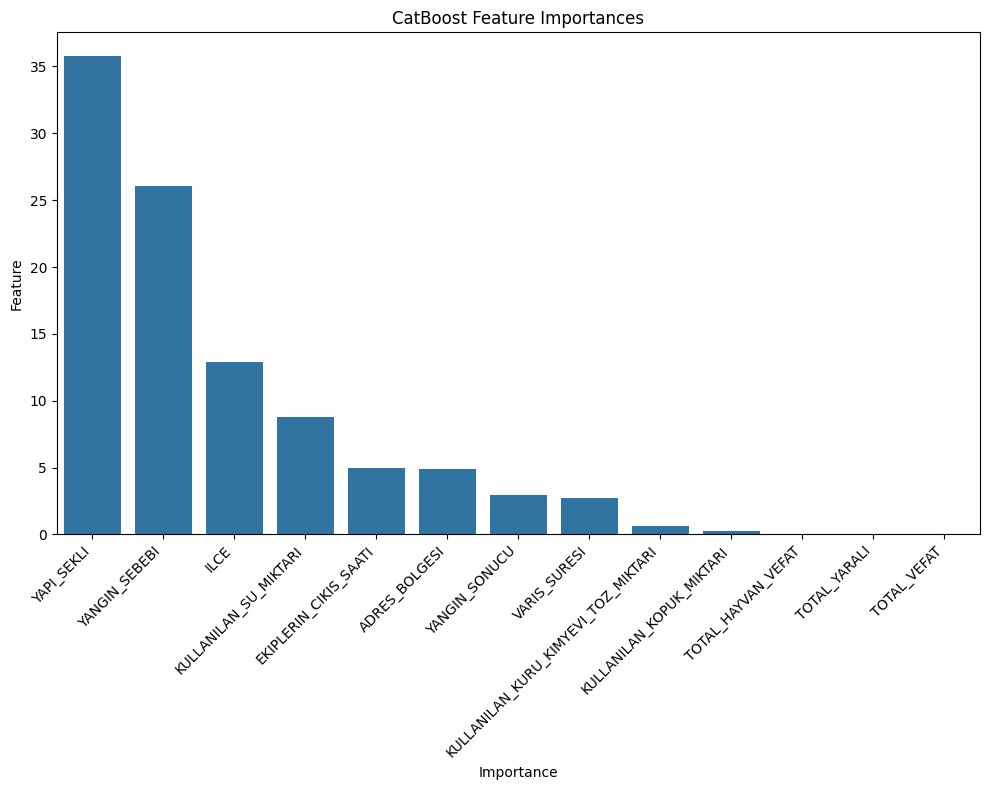

In [9]:
# Importance of the features
importances = catboost_classifier.get_feature_importance(prettified=True)
importances = importances.sort_values(by="Importances", ascending=False)

print(f"Top 5 feature importances:{importances["Feature Id"][:5].tolist()}")

plt.figure(figsize=(10, 8))
sns.barplot(y="Importances", x="Feature Id", data=importances)
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../reports/figures/catboost_feature_importances.png", transparent=True, dpi=300)
plt.show()

In [10]:
# One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("no_scale", "passthrough", no_scale_features),
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Split the test set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

                                              precision    recall  f1-score   support

                Altyapı - Ekipman Yangınları       0.02      0.03      0.03        37
                             Araç Yangınları       0.06      0.06      0.06       110
Atık - Hurda - Depolanmış Malzeme Yangınları       0.25      0.26      0.25       336
     Bitki Örtüsü - Tarımsal Alan Yangınları       0.35      0.35      0.35       499
                  Diğer - Belirsiz Yangınlar       0.17      0.20      0.18         5
                    Yapı - Mesken Yangınları       0.24      0.23      0.23       311

                                    accuracy                           0.26      1298
                                   macro avg       0.18      0.19      0.18      1298
                                weighted avg       0.26      0.26      0.26      1298

F1 Score: 0.1844
Matthews Correlation Coefficient: -0.0226


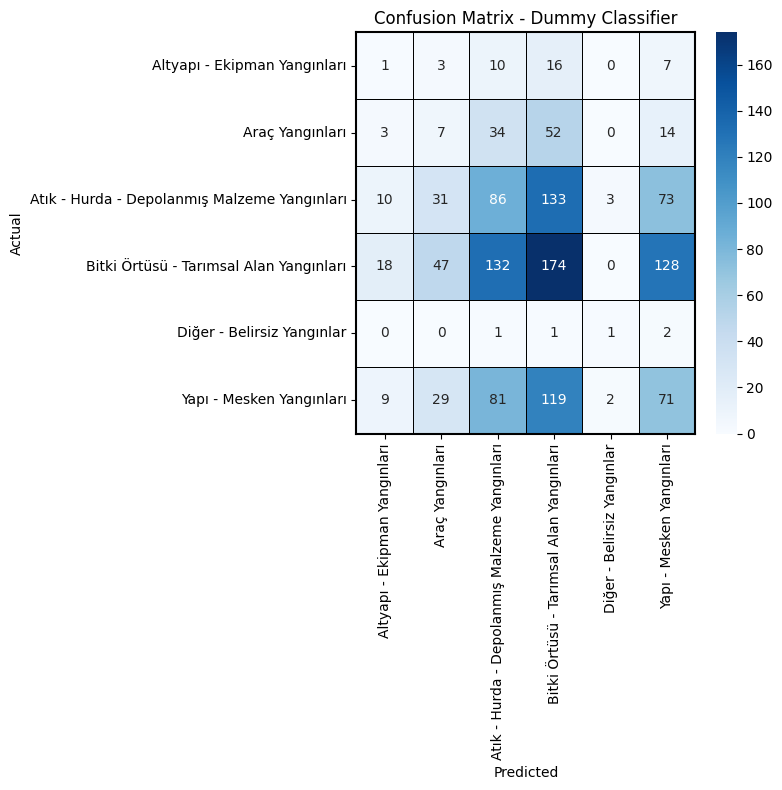

In [11]:
# Dummy Classifier with stratified strategy for baseline comparison
baseline_model = DummyClassifier(strategy="stratified", random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)

# Evaluate the baseline model
print(classification_report(y_test, y_pred_baseline, target_names=baseline_model.classes_))
print(f"F1 Score: {f1_score(y_test, y_pred_baseline, average='macro'):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_baseline):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linecolor="black",
    linewidths=0.65,
    xticklabels=baseline_model.classes_,
    yticklabels=baseline_model.classes_,
    cbar=True,
)
ax.set_title("Confusion Matrix - Dummy Classifier")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Draw all borders
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix_dummy_classifier.png", transparent=True, dpi=300)
plt.show()

In [12]:
param_dist = {
    "iterations": [500, 1000, 2000],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],  # Step size shrinkage
    "depth": [3, 4, 5, 6, 7],  # Depth of the tree
    "l2_leaf_reg": [1, 3, 5, 7, 9],  # L2 regularization
    "border_count": [32, 64, 128, 256],  # For numerical feature splits
    "bagging_temperature": [0.2, 0.5, 1],  # Controls the amount of randomness in bagging
    "random_strength": [1, 5, 10],  # Randomness for scoring splits
}
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)

fit_params_tuning = {"early_stopping_rounds": 150}  # Reduced slightly as X_valid is smaller

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter settings that are sampled.
    cv=3,  # Number of cross-validation folds (applied on X_train, y_train)
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Set to higher for more output
)
random_search.fit(X_valid, y_valid, **fit_params_tuning)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7abd4ea10800>,
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0.2, 0.5, 1],
                                        'border_count': [32, 64, 128, 256],
                                        'depth': [3, 4, 5, 6, 7],
                                        'iterations': [500, 1000, 2000],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'random_strength': [1, 5, 10]},
                   random_state=42, scoring='f1_macro', verbose=1)

In [13]:
best_params_from_valid = random_search.best_params_
print(f"Best Parameters found: {best_params_from_valid}")
print(f"Best F1 score during: {random_search.best_score_:.4f}")

Best Parameters found: {'random_strength': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 2000, 'depth': 6, 'border_count': 32, 'bagging_temperature': 0.2}
Best F1 score during: 0.6518


In [14]:
catboost_model = CatBoostClassifier(**best_params_from_valid, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train, early_stopping_rounds=150)

                                              precision    recall  f1-score   support

                Altyapı - Ekipman Yangınları       0.78      0.49      0.60        37
                             Araç Yangınları       0.80      0.86      0.83       110
Atık - Hurda - Depolanmış Malzeme Yangınları       0.70      0.67      0.68       336
     Bitki Örtüsü - Tarımsal Alan Yangınları       0.78      0.80      0.79       499
                  Diğer - Belirsiz Yangınlar       0.43      0.60      0.50         5
                    Yapı - Mesken Yangınları       0.99      0.99      0.99       311

                                    accuracy                           0.81      1298
                                   macro avg       0.75      0.74      0.73      1298
                                weighted avg       0.81      0.81      0.81      1298

F1 Score: 0.7328
MCC: 0.7350


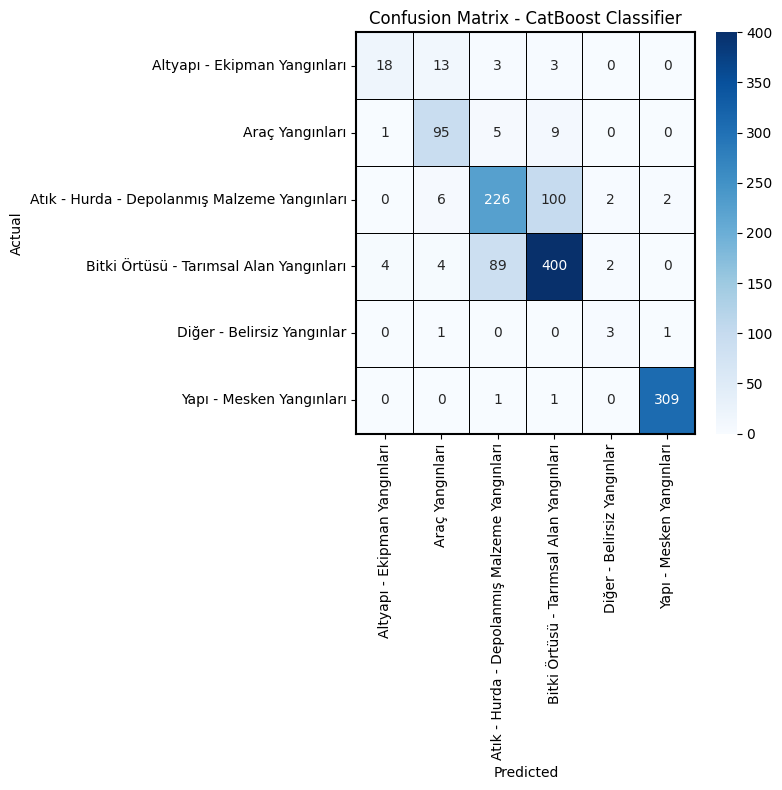

In [15]:
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)

# Evaluate the model on the test set
print(classification_report(y_test, y_pred, zero_division=0))
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linecolor="black",
    linewidths=0.65,
    xticklabels=catboost_model.classes_,
    yticklabels=catboost_model.classes_,
    cbar=True,
)
ax.set_title("Confusion Matrix - CatBoost Classifier")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Draw all borders
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor("black")


plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix_catboost_classifier.png", transparent=True, dpi=300)

plt.show()

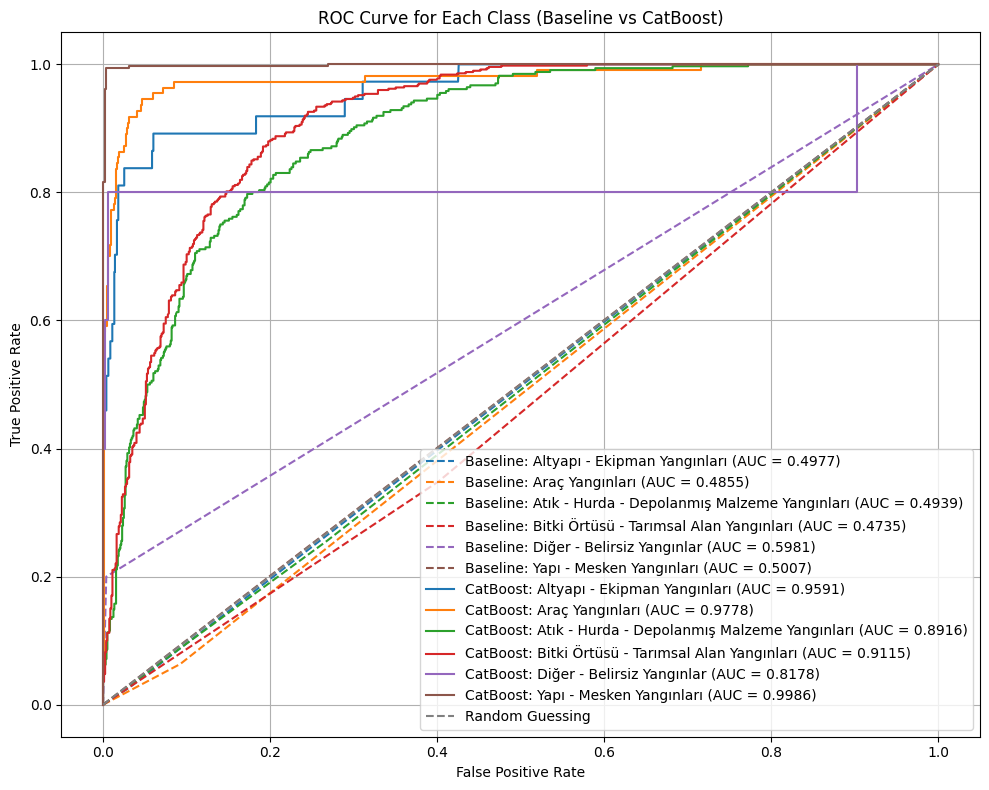

In [16]:
# ROC Curve for each class in single figure (same color for each class, solid for CatBoost, dashed for baseline)
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  # Use tab10 colormap for up to 10 classes

for i, class_name in enumerate(baseline_model.classes_):
    color = colors[i % len(colors)]
    fpr, tpr, _ = roc_curve(y_test == class_name, y_pred_proba_baseline[:, i])
    roc_auc = roc_auc_score(y_test == class_name, y_pred_proba_baseline[:, i])
    plt.plot(fpr, tpr, label=f"Baseline: {class_name} (AUC = {roc_auc:.4f})", linestyle="--", color=color)

for i, class_name in enumerate(catboost_model.classes_):
    color = colors[i % len(colors)]
    fpr, tpr, _ = roc_curve(y_test == class_name, y_pred_proba[:, i])
    roc_auc = roc_auc_score(y_test == class_name, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"CatBoost: {class_name} (AUC = {roc_auc:.4f})", linestyle="-", color=color)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.title("ROC Curve for Each Class (Baseline vs CatBoost)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig("../reports/figures/roc_curve_comparison.png", transparent=True, dpi=300)
plt.show()

In [17]:
print(df["YANGIN_TURU"].value_counts().to_markdown())

| YANGIN_TURU                                  |   count |
|:---------------------------------------------|--------:|
| Bitki Örtüsü - Tarımsal Alan Yangınları      |    4982 |
| Atık - Hurda - Depolanmış Malzeme Yangınları |    3361 |
| Yapı - Mesken Yangınları                     |    3108 |
| Araç Yangınları                              |    1098 |
| Altyapı - Ekipman Yangınları                 |     366 |
| Diğer - Belirsiz Yangınlar                   |      56 |


In [18]:
df["VARIS_SURESI"] = df["VARIS_SURESI"].clip(lower=1)
df["KULLANILAN_SU_MIKTARI"] = df["KULLANILAN_SU_MIKTARI"].clip(lower=0)

In [19]:
df.groupby("YANGIN_TURU").agg(
    mean_varis_suresi=("VARIS_SURESI", "mean"),
    std_varis_suresi=("VARIS_SURESI", "std"),
    count_varis_suresi=("VARIS_SURESI", "count"),
    mean_su_miktari=("KULLANILAN_SU_MIKTARI", "mean"),
    std_su_miktari=("KULLANILAN_SU_MIKTARI", "std"),
).sort_values(by="count_varis_suresi", ascending=False)

,mean_varis_suresi,std_varis_suresi,count_varis_suresi,mean_su_miktari,std_su_miktari
YANGIN_TURU,,,,,
Bitki Örtüsü - Tarımsal Alan Yangınları,6.968888,6.571861,4982,4.243294,21.688267
Atık - Hurda - Depolanmış Malzeme Yangınları,5.322523,25.055334,3361,3.018584,16.337910
Yapı - Mesken Yangınları,4.979408,3.877621,3108,5.888600,41.611590
Araç Yangınları,5.486339,3.915504,1098,1.329809,4.630110
Altyapı - Ekipman Yangınları,5.177596,3.036516,366,1.024645,10.570566
Diğer - Belirsiz Yangınlar,5.232143,3.357440,56,18.857321,94.140006


In [18]:
# Hypotheses for VARIS_SURESI:
# H0: The mean response time is the same across all fire types.
# Ha: At least one fire type has a different mean response time.


Normality Check for VARIS_SURESI (Shapiro-Wilk per group):
YANGIN_TURU
Altyapı - Ekipman Yangınları                    False
Araç Yangınları                                 False
Atık - Hurda - Depolanmış Malzeme Yangınları    False
Bitki Örtüsü - Tarımsal Alan Yangınları         False
Diğer - Belirsiz Yangınlar                      False
Yapı - Mesken Yangınları                        False
Name: VARIS_SURESI, dtype: bool
If 'False' for any group, normality assumption might be violated for that group.

Q-Q Plots for VARIS_SURESI by fire type (first 6 types):


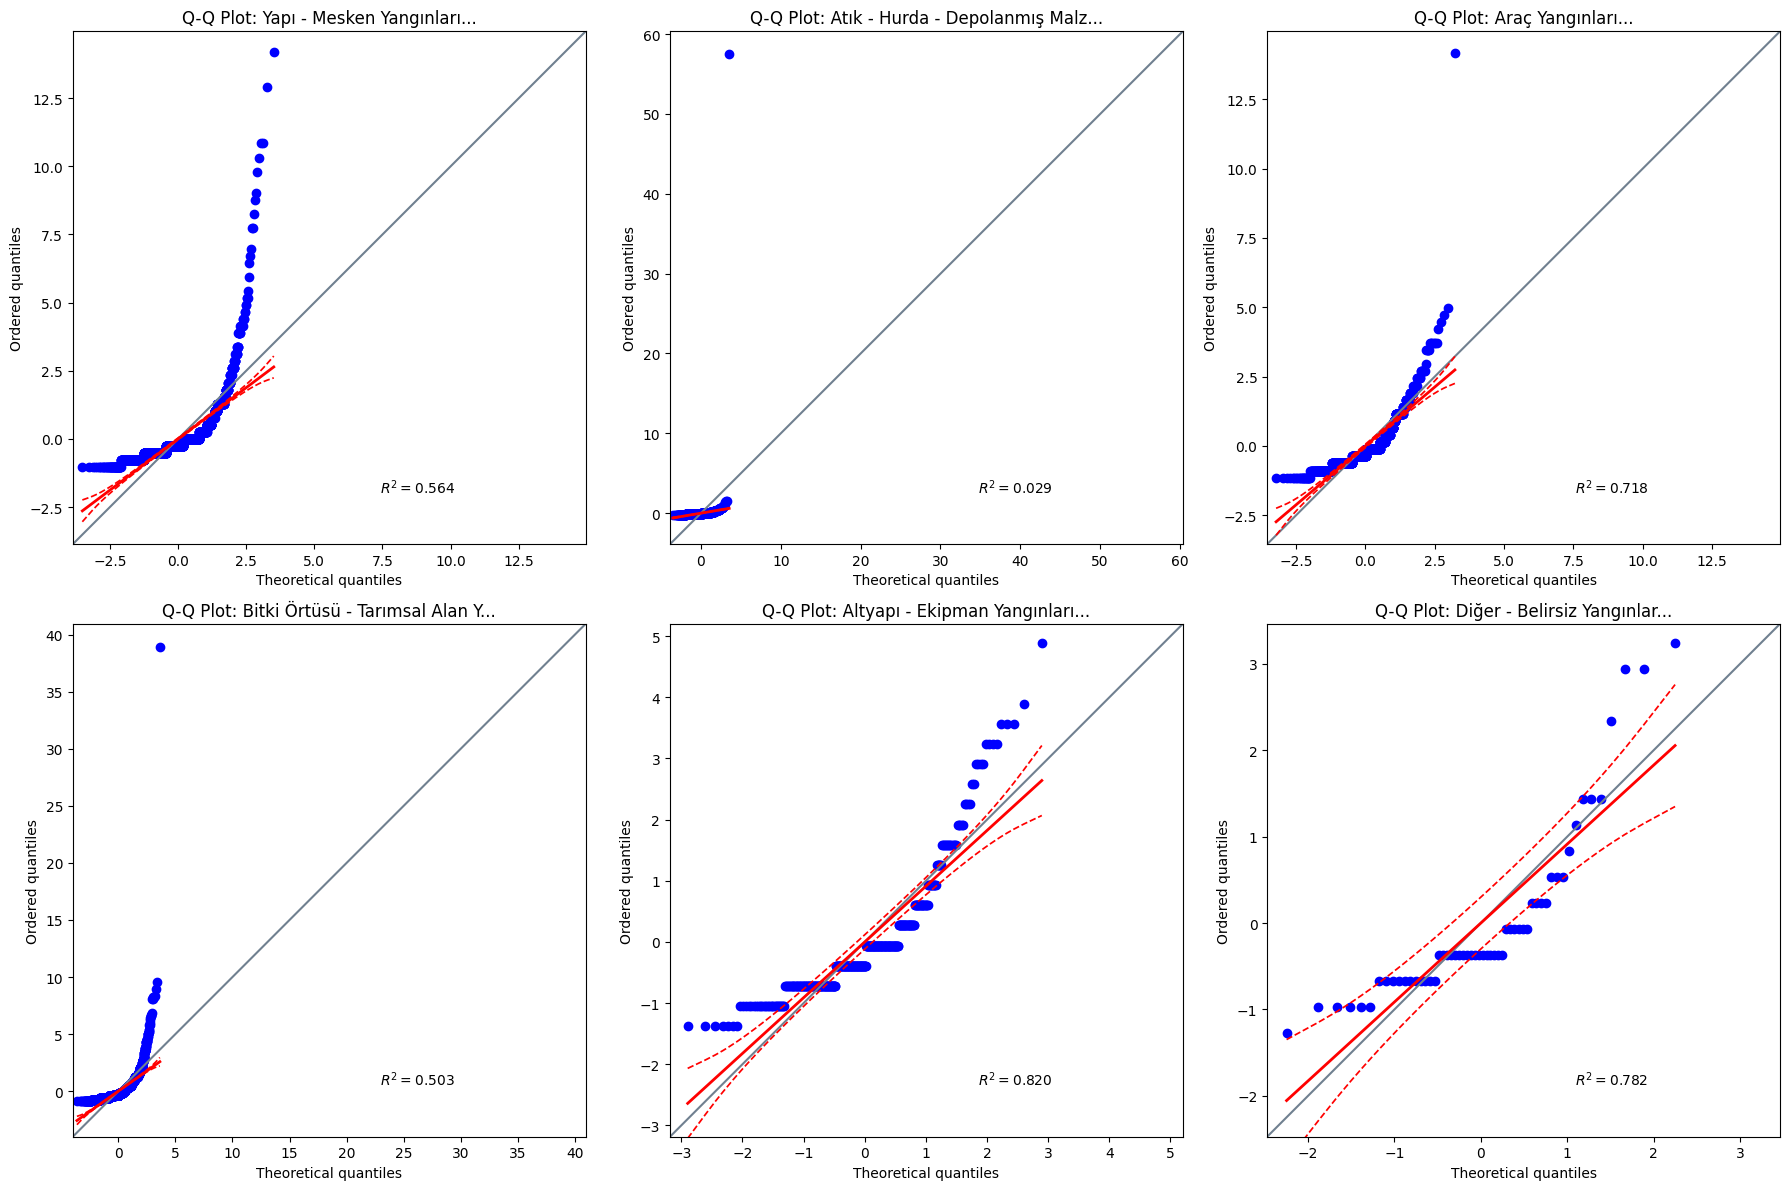

In [20]:
# Normality Check (using Shapiro-Wilk for each group, as group sizes vary)
# Pingouin's normality test can be applied to residuals if an ANOVA model is fitted first, or on each group separately.

print("\nNormality Check for VARIS_SURESI (Shapiro-Wilk per group):")

normality_results_varis = df.groupby("YANGIN_TURU")["VARIS_SURESI"].apply(
    lambda x: pg.normality(x, method="shapiro", alpha=0.05)["normal"].iloc[0] if len(x) >= 3 else pd.NA
)

print(normality_results_varis)
print("If 'False' for any group, normality assumption might be violated for that group.")

# Visual check for normality (histograms and Q-Q plots)
print("\nQ-Q Plots for VARIS_SURESI by fire type (first 6 types):")
plt.figure(figsize=(18, 12))
for i, fire_type in enumerate(df["YANGIN_TURU"].unique()[:6]):
    plt.subplot(2, 3, i + 1)
    pg.qqplot(df[df["YANGIN_TURU"] == fire_type]["VARIS_SURESI"], dist="norm")
    plt.title(f"Q-Q Plot: {fire_type[:30]}...")
plt.tight_layout()
plt.savefig("../reports/figures/qq_plots_varis_suresi.png", transparent=True, dpi=300)
plt.show()

In [21]:
# Homogeneity of Variances Check (Levene's Test)
print("\nHomogeneity of Variances Check for VARIS_SURESI (Levene's Test):")

levene_test_varis = pg.homoscedasticity(data=df, dv="VARIS_SURESI", group="YANGIN_TURU", method="levene", alpha=0.05)
print(levene_test_varis)

variances_equal_varis = levene_test_varis["equal_var"].iloc[0]
print(f"Are variances equal for VARIS_SURESI? {'Yes' if variances_equal_varis else 'No'}")

if not variances_equal_varis:
    print(
        "Levene's test is significant: There are significant differences in the variability (variances) of response times among different fire categories."
    )
else:
    print("Levene's test is not significant: No significant differences in the variability (variances) of response times found.")


Homogeneity of Variances Check for VARIS_SURESI (Levene's Test):
               W      pval  equal_var
levene  3.987143  0.001292      False
Are variances equal for VARIS_SURESI? No
Levene's test is significant: There are significant differences in the variability (variances) of response times among different fire categories.


In [22]:
# Perform ANOVA / Welch's ANOVA for VARIS_SURESI
if variances_equal_varis:
    print("\nPerforming ANOVA for VARIS_SURESI (variances are equal).")
    aov_varis = pg.anova(data=df, dv="VARIS_SURESI", between="YANGIN_TURU", detailed=True)
else:
    print("\nPerforming Welch's ANOVA for VARIS_SURESI (variances are unequal).")
    aov_varis = pg.welch_anova(data=df, dv="VARIS_SURESI", between="YANGIN_TURU")

print(aov_varis)
print(f"Are the means significantly different? {'Yes' if aov_varis['p-unc'].iloc[0] < 0.05 else 'No'}")


Performing Welch's ANOVA for VARIS_SURESI (variances are unequal).
        Source  ddof1       ddof2          F         p-unc     np2
0  YANGIN_TURU      5  550.790612  60.676358  2.455448e-50  0.0041
Are the means significantly different? Yes


In [23]:
# The p-value is in 'p-unc' for ANOVA or 'p-val' for Welch's ANOVA.
p_value_varis = aov_varis["p-unc"].iloc[0] if "p-unc" in aov_varis.columns else aov_varis["p-val"].iloc[0]

if p_value_varis < 0.05:
    print("\nANOVA/Welch's ANOVA is significant. Performing post-hoc test for VARIS_SURESI.")
    if variances_equal_varis:
        print("Using Tukey's HSD (variances were equal).")
        posthoc_varis = pg.pairwise_tukey(data=df, dv="VARIS_SURESI", between="YANGIN_TURU")
    else:
        print("Using Games-Howell (variances were unequal).")
        posthoc_varis = pg.pairwise_gameshowell(data=df, dv="VARIS_SURESI", between="YANGIN_TURU")
    print(posthoc_varis[posthoc_varis["pval"] < 0.05])  # Show only significant differences
else:
    print("\nANOVA/Welch's ANOVA is not significant. No significant differences in mean response times found.")


ANOVA/Welch's ANOVA is significant. Performing post-hoc test for VARIS_SURESI.
Using Games-Howell (variances were unequal).
                                               A  \
2                   Altyapı - Ekipman Yangınları   
6                                Araç Yangınları   
8                                Araç Yangınları   
9   Atık - Hurda - Depolanmış Malzeme Yangınları   
12       Bitki Örtüsü - Tarımsal Alan Yangınları   
13       Bitki Örtüsü - Tarımsal Alan Yangınları   

                                          B   mean(A)   mean(B)      diff  \
2   Bitki Örtüsü - Tarımsal Alan Yangınları  5.177596  6.968888 -1.791292   
6   Bitki Örtüsü - Tarımsal Alan Yangınları  5.486339  6.968888 -1.482549   
8                  Yapı - Mesken Yangınları  5.486339  4.979408  0.506931   
9   Bitki Örtüsü - Tarımsal Alan Yangınları  5.322523  6.968888 -1.646365   
12               Diğer - Belirsiz Yangınlar  6.968888  5.232143  1.736745   
13                 Yapı - Mesken Yangınları  6.9

In [24]:
# Hypotheses for KULLANILAN_SU_MIKTARI:
# H0: The mean water usage is the same across all fire types.
# Ha: At least one fire type has a different mean water usage.


Normality Check for KULLANILAN_SU_MIKTARI (Shapiro-Wilk per group):


YANGIN_TURU
Altyapı - Ekipman Yangınları                    False
Araç Yangınları                                 False
Atık - Hurda - Depolanmış Malzeme Yangınları    False
Bitki Örtüsü - Tarımsal Alan Yangınları         False
Diğer - Belirsiz Yangınlar                      False
Yapı - Mesken Yangınları                        False
Name: KULLANILAN_SU_MIKTARI, dtype: bool
If 'False' for any group, normality assumption might be violated for that group.

Q-Q Plots for KULLANILAN_SU_MIKTARI by fire type (first 6 types):


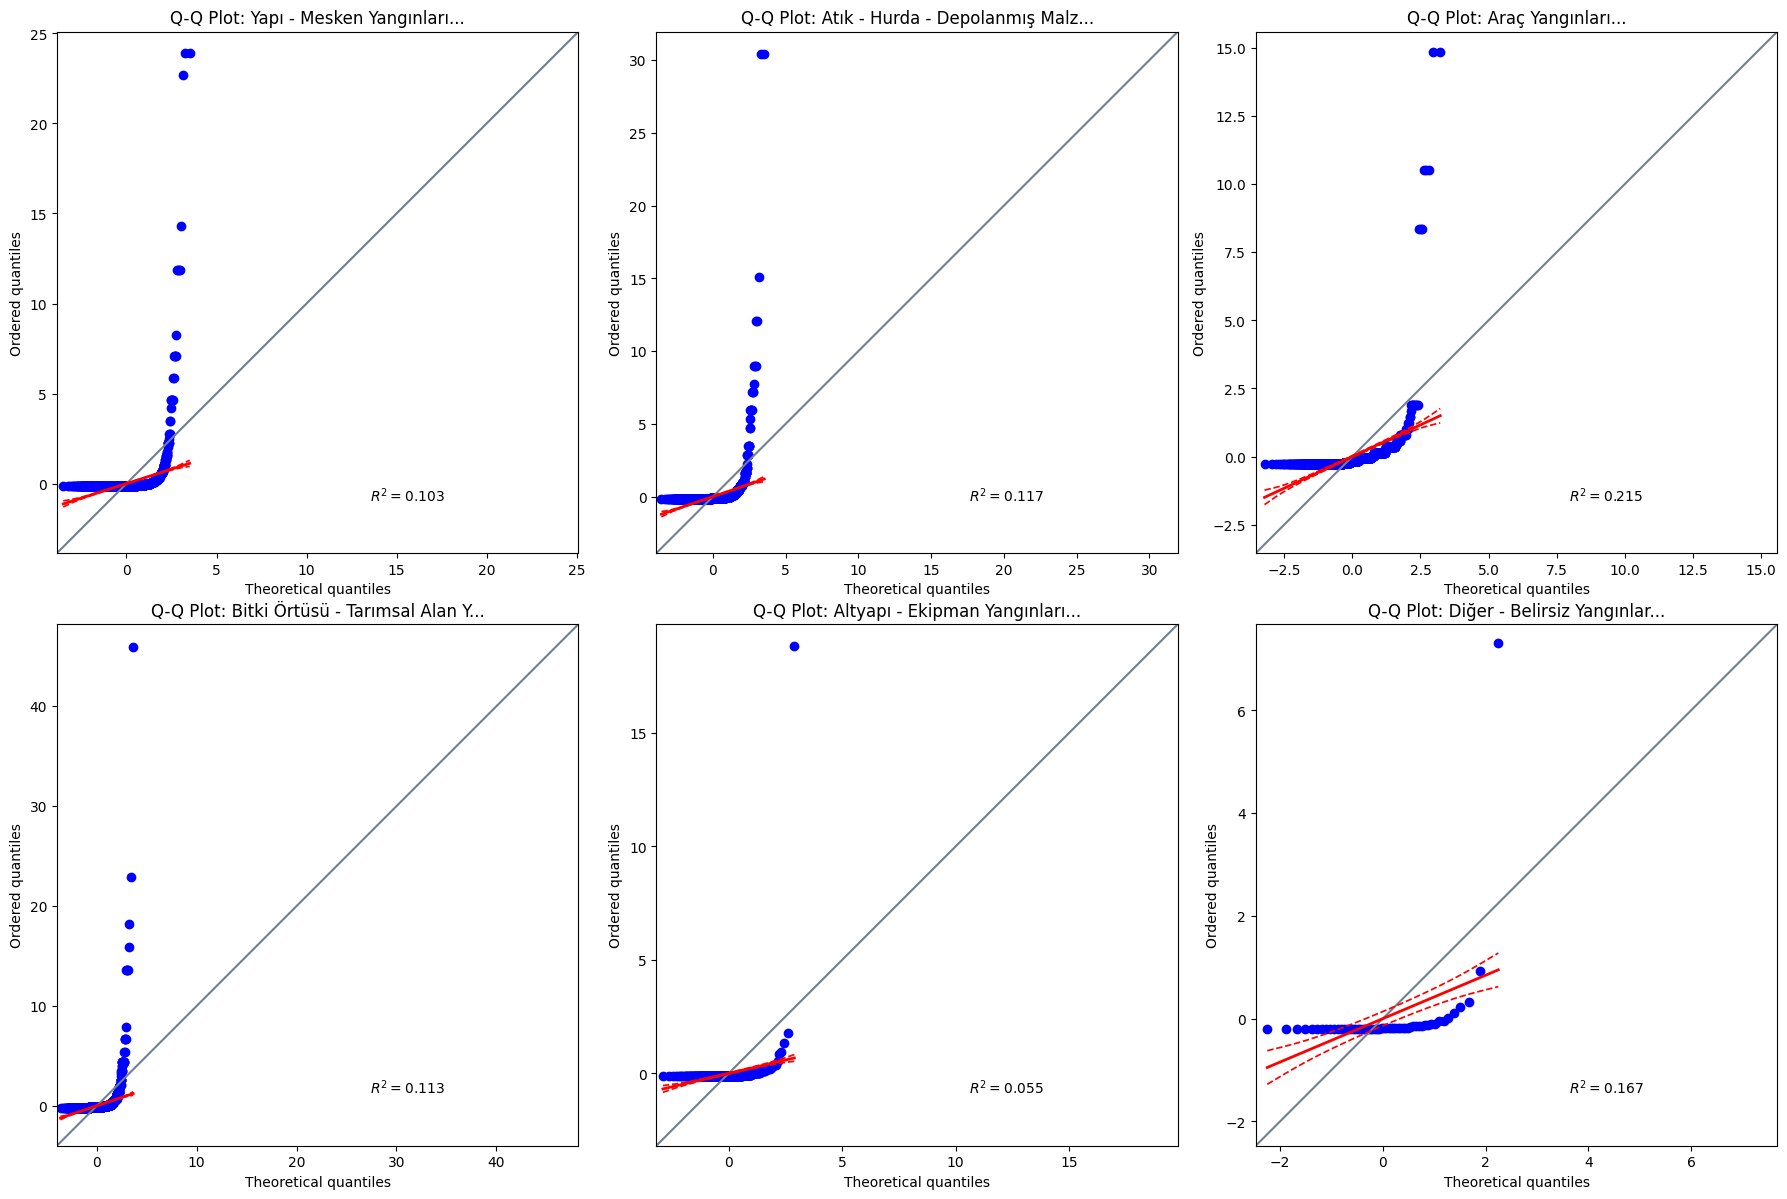

In [25]:
# Normality Check (Shapiro-Wilk per group)
print("\nNormality Check for KULLANILAN_SU_MIKTARI (Shapiro-Wilk per group):")
normality_results_su = df.groupby("YANGIN_TURU")["KULLANILAN_SU_MIKTARI"].apply(
    lambda x: pg.normality(x, method="shapiro", alpha=0.05)["normal"].iloc[0] if len(x) >= 3 else pd.NA
)
print(normality_results_su)
print("If 'False' for any group, normality assumption might be violated for that group.")


# Visual check for normality (histograms and Q-Q plots) - often skewed for usage data
print("\nQ-Q Plots for KULLANILAN_SU_MIKTARI by fire type (first 6 types):")
plt.figure(figsize=(18, 12))
for i, fire_type in enumerate(df["YANGIN_TURU"].unique()[:6]):
    plt.subplot(2, 3, i + 1)
    pg.qqplot(df[df["YANGIN_TURU"] == fire_type]["KULLANILAN_SU_MIKTARI"], dist="norm")
    plt.title(f"Q-Q Plot: {fire_type[:30]}...")
plt.tight_layout()
plt.savefig("../reports/figures/qq_plots_kullanilan_su_miktari.png", transparent=True, dpi=300)
plt.show()

In [26]:
# Homogeneity of Variances Check (Levene's Test for variability)
print("\nHomogeneity of Variances Check for KULLANILAN_SU_MIKTARI (Levene's Test):")

levene_test_su = pg.homoscedasticity(data=df, dv="KULLANILAN_SU_MIKTARI", group="YANGIN_TURU", method="levene", alpha=0.05)
print(levene_test_su)

variances_equal_su = levene_test_su["equal_var"].iloc[0]
print(f"Are variances equal for KULLANILAN_SU_MIKTARI? {'Yes' if variances_equal_su else 'No'}")

if not variances_equal_su:
    print(
        "Levene's test is significant: There are significant differences in the variability (variances) of water usage among different fire categories."
    )
else:
    print("Levene's test is not significant: No significant differences in the variability (variances) of water usage found.")


Homogeneity of Variances Check for KULLANILAN_SU_MIKTARI (Levene's Test):
                W          pval  equal_var
levene  11.161637  9.391470e-11      False
Are variances equal for KULLANILAN_SU_MIKTARI? No
Levene's test is significant: There are significant differences in the variability (variances) of water usage among different fire categories.


In [27]:
# Perform ANOVA / Welch's ANOVA for KULLANILAN_SU_MIKTARI (to check mean differences)
if variances_equal_su:
    print("\nPerforming ANOVA for KULLANILAN_SU_MIKTARI (variances are equal by Levene's).")
    aov_su = pg.anova(data=df, dv="KULLANILAN_SU_MIKTARI", between="YANGIN_TURU", detailed=True)
else:
    print("\nPerforming Welch's ANOVA for KULLANILAN_SU_MIKTARI (variances are unequal by Levene's).")
    aov_su = pg.welch_anova(data=df, dv="KULLANILAN_SU_MIKTARI", between="YANGIN_TURU")

print(aov_su)


Performing Welch's ANOVA for KULLANILAN_SU_MIKTARI (variances are unequal by Levene's).
        Source  ddof1       ddof2         F         p-unc       np2
0  YANGIN_TURU      5  543.095013  24.07099  6.646337e-22  0.004128


In [27]:
# Post-hoc Test for KULLANILAN_SU_MIKTARI (if ANOVA for means is significant)
p_value_su = aov_su["p-unc"].iloc[0] if "p-unc" in aov_su.columns else aov_su["p-val"].iloc[0]

if p_value_su < 0.05:
    print("\nANOVA/Welch's ANOVA for means is significant. Performing post-hoc test for KULLANILAN_SU_MIKTARI.")
    if variances_equal_su:  # Though Levene's might have been significant for variability, if we used standard ANOVA for means:
        print("Using Tukey's HSD (assuming standard ANOVA was chosen based on other criteria).")
        posthoc_su = pg.pairwise_tukey(data=df, dv="KULLANILAN_SU_MIKTARI", between="YANGIN_TURU")
    else:  # More likely if Levene's was significant
        print("Using Games-Howell (variances were unequal).")
        posthoc_su = pg.pairwise_gameshowell(data=df, dv="KULLANILAN_SU_MIKTARI", between="YANGIN_TURU")
    print(posthoc_su[posthoc_su["pval"] < 0.05])  # Show only significant differences
else:
    print("\nANOVA/Welch's ANOVA for means is not significant. No significant differences in mean water usage found.")


ANOVA/Welch's ANOVA for means is significant. Performing post-hoc test for KULLANILAN_SU_MIKTARI.
Using Games-Howell (variances were unequal).
                                               A  \
1                   Altyapı - Ekipman Yangınları   
2                   Altyapı - Ekipman Yangınları   
4                   Altyapı - Ekipman Yangınları   
5                                Araç Yangınları   
6                                Araç Yangınları   
8                                Araç Yangınları   
9   Atık - Hurda - Depolanmış Malzeme Yangınları   
11  Atık - Hurda - Depolanmış Malzeme Yangınları   

                                               B   mean(A)   mean(B)  \
1   Atık - Hurda - Depolanmış Malzeme Yangınları  1.024645  3.018584   
2        Bitki Örtüsü - Tarımsal Alan Yangınları  1.024645  4.243294   
4                       Yapı - Mesken Yangınları  1.024645  5.888600   
5   Atık - Hurda - Depolanmış Malzeme Yangınları  1.329809  3.018584   
6        Bitki Örtüsü - Tar